## Tuning facebook:wav2vec2-large-960h

Here, we finetune the facebook:wav2vec2-large-960h model from huggingface using the `cv-valid-train` common_voice dataset. This notebook follows the finetuning framework from this [hugginface blog](https://huggingface.co/blog/fine-tune-wav2vec2-english) with minor adaptations. First, we import the required libraries.

In [58]:
# Imports
import os
import re
import random
from dataclasses import dataclass, field
from typing import Any, Dict, List, Optional, Union
import gc
from multiprocessing import Pool, cpu_count

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from IPython.display import Audio as PlayAudio

from accelerate import Accelerator
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC, Wav2Vec2CTCTokenizer, Wav2Vec2FeatureExtractor
from transformers import TrainingArguments, Trainer
from datasets import load_dataset, Audio, DatasetDict, load_from_disk, Dataset
import evaluate

import torch
from torch.utils.data import DataLoader
import torchaudio
from transformers import get_linear_schedule_with_warmup
from torch.utils.tensorboard import SummaryWriter
from torch.optim import AdamW
from torch.amp import autocast, GradScaler
from tqdm import tqdm

from pydub import AudioSegment
import soundfile as sf
from mutagen import File

from jiwer import wer

HOME_DIR = os.path.expanduser('~')

In [59]:
# Helpers
from pynvml import nvmlInit, nvmlDeviceGetHandleByIndex, nvmlDeviceGetMemoryInfo

def print_gpu_utilization():
    nvmlInit()
    handle = nvmlDeviceGetHandleByIndex(0)
    info = nvmlDeviceGetMemoryInfo(handle)
    print(f"GPU memory occupied: {info.used//1024**2} MB.")


def print_summary(result):
    print(f"Time: {result.metrics['train_runtime']:.2f}")
    print(f"Samples/second: {result.metrics['train_samples_per_second']:.2f}")
    print_gpu_utilization()

### Pre-processing

We first convert all mp3 files to wav files, which the wav2vec2 model assumes. Additionally converting transcript texts to upper case to match the original model. This may take some time.

In [60]:
# File locations. All files assumed placed in asr_proejct folder
audio_or_dir = os.path.join(HOME_DIR,'asr_project/common_voice/cv-valid-train/')
audio_dir = os.path.join(HOME_DIR,'asr_project/common_voice/cv-valid-train/cv-valid-train/')
audioloc_transcript_or_dir = os.path.join(HOME_DIR,'asr_project/common_voice/cv-valid-train.csv')
audioloc_transcript_dir = os.path.join(HOME_DIR,'asr_project/asr-train/selected_transcript.csv')
temp_dir = os.path.join(HOME_DIR,'asr_project/asr-train/temp.csv')

In [4]:
# # Function to convert mp3 to wav
# def convert_mp3_to_wav(mp3_file):
#     # Generate the output wav file path
#     wav_file = mp3_file.replace('.mp3', '.wav')
    
#     # Convert mp3 to wav if wav file does not exist
#     if not os.path.exists(wav_file):
#         waveform, sample_rate = torchaudio.load(mp3_file)
#         torchaudio.save(wav_file, waveform, sample_rate)
    
#     return wav_file


# df = pd.read_csv(audioloc_transcript_or_dir)

# # Convert mp3 to wav. Change mp3 file extension in df accordingly
# df['filename'] = df['filename'].apply(
#     lambda filename: convert_mp3_to_wav(
#         os.path.join(audio_or_dir, filename)))

# # Put texts to uppercase to match pre-finetuned model
# df['text'] = df['text'].str.upper()
# df['filename'] = df['filename'].map(lambda x: os.path.basename(x))

# df_transcript = df

Checking audio file characteristics ...

In [5]:
# def get_audio_info(file_path):
#     # Extract filename and extension
#     file_name, file_ext = os.path.splitext(os.path.basename(file_path))
#     file_size = os.path.getsize(file_path)  # Size in bytes

#     # Try to get audio length with mutagen
#     try:
#         audio = File(file_path)
#         audio_length = audio.info.length if audio and audio.info else None
#     except Exception as e:
#         print(f"Could not process file {file_name}: {e}")
#         audio_length = None

#     return {
#         'filename': file_name,
#         'extension': file_ext,
#         'size_bytes': file_size,
#         'length_seconds': audio_length
#     }

# def process_directory(directory):
#     # List all audio files in directory
#     audio_files = [
#         os.path.join(directory, f) for f in os.listdir(directory) 
#         if os.path.isfile(os.path.join(directory, f))
#     ]

#     # Use tqdm with multiprocessing
#     with Pool(cpu_count()) as pool:
#         # Wrap audio files list with tqdm for progress bar
#         audio_info = list(tqdm(pool.imap(get_audio_info, audio_files), total=len(audio_files), desc="Processing files"))

#     # Create DataFrame from the list of dictionaries
#     df = pd.DataFrame(audio_info)
#     return df

# # Get audio file information
# audio_df = process_directory(audio_dir)
# audio_df_mp3 = audio_df.loc[audio_df['extension']=='.mp3'].copy()
# audio_df_wav = audio_df.loc[audio_df['extension']=='.wav'].copy().drop(columns=['length_seconds'])
# audio_df_wav = audio_df_wav.merge(audio_df_mp3[['filename','length_seconds']], on='filename', how='left')
# audio_df_wav['filename'] = audio_df_wav['filename'].map(lambda x: x+'.wav')
# audio_df_wav.head()

We see that some of them have very high durations, up to 6 minutes long.

In [6]:
# audio_df_wav.describe()

Checking the transcript, we find that the longest line read is only 33 words long, which should not take that long to read.

In [7]:
# df_transcript['len'] = df_transcript['text'].str.len()
# df_transcript = df_transcript[['filename','len','text']]

# filename_longest = df_transcript.loc[df_transcript['len']==df_transcript['len'].max(), 'filename'].item()
# text_longest = df_transcript.loc[df_transcript['len']==df_transcript['len'].max(), 'text'].item()

# print(f'Filename with longest transcript: {filename_longest}')
# print(f'Longest transcript text: {text_longest}')

# longest_clip_duration = audio_df_wav.loc[audio_df_wav['filename']==filename_longest,'length_seconds'].item()
# print(f'Longest transcript duration: {longest_clip_duration}s')

The clip with the longest transcript is 11s long. Considering differences in reading speeds, we assume the longest legitimate script reading to be 15s long. __We discard all samples with durations above 15s__. This will help prevent memory issues during model finetuning. We drop a total of 397 samples, keeping ~195k samples, saving a copy as csv file for later reference.

In [8]:
# df_transcript = df_transcript.merge(audio_df_wav[['filename', 'length_seconds']], on='filename', how='left')
# (df_transcript['length_seconds'] > 15).sum().item(),  (df_transcript['length_seconds'] < 15).sum().item()

In [9]:
# df_transcript = df_transcript.loc[df_transcript['length_seconds']<15].drop(columns=['len','length_seconds'])
# df_transcript.to_csv(audioloc_transcript_dir, index=False)

We create a `DatasetDict` for easy access to train-val splits.

In [10]:
# # Load csv file with wav filenames, complete path and create dataset
# df = pd.read_csv(audioloc_transcript_dir)
# df['filename'] = df['filename'].map(lambda x: os.path.join(audio_dir,x))
# df.to_csv(temp_dir,index=False)

In [11]:
# dataset = load_dataset('csv', data_files=temp_dir, split='train')
# dataset = dataset.cast_column("filename",
#                               Audio(sampling_rate=16000))         # Cast audio files with 16kHz sampling rate

# # train-val 70-30 split
# dataset = dataset.train_test_split(test_size=0.3, seed=42)        # Split to train-val

# # Final, combined dataset
# dataset = DatasetDict({
#     'train': dataset['train'],
#     'val': dataset['test']})

# dataset

We will make use of the tokenizer and processor from `facebook/wav2vec2-large-960h` in the model finetuning below. First, the transcripts are converted to the format expected by the model. The transcript have already been converted into uppercase earlier for this purpose. We insert start, end, and delimited tokens below.

In [12]:
# # Following the style of facebook/wav2ec2-large-960h model
# start_token = "<s>"
# end_token = "</s>"
# word_delimiter_token = "|"

# # Define the preprocessing function
# def preprocess_transcript(example):
#     transcript = example['text']  # Assuming the column with text is named 'text'
    
#     # Step 1: Replace multiple spaces with a single space
#     transcript = re.sub(r'\s+', ' ', transcript)  # Remove extra spaces
    
#     # Step 2: Add start and end tokens, and replace spaces with '|'
#     processed_transcript = start_token + transcript.replace(" ", f"{word_delimiter_token}") + end_token
    
#     return {"processed_text": processed_transcript}  # Return the processed text in a dictionary

# # Apply the preprocessing to both train and validation splits
# dataset = dataset.map(preprocess_transcript, remove_columns=["text"],num_proc=4)

Converting to column names expected by model.

In [13]:
# dataset = dataset.rename_column("filename", "input_values")
# dataset = dataset.rename_column("processed_text", "labels")

Then, we tokenize the transcripts and use the `input_values` and `labels` column names in the datasets.

In [14]:
# # Load processor
# processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-large-960h")

# def prepare_dataset(batch):
#     # Process 'input_values' column for 1D waveform values
#     batch["input_values"] = processor(batch["input_values"]["array"],
#                                       sampling_rate=16000).input_values[0]
    
#     # Process the 'labels' column to create 'labels' (text data)
#     batch["labels"] = processor(text=batch["labels"]).input_ids
    
#     return batch

# # Map the dataset transformation to both 'train' and 'val' splits
# dataset = dataset.map(prepare_dataset, num_proc=2)


In [15]:
# # Save the dataset to a directory
# dataset.save_to_disk("temp_dataset")

For a quick check, play a random audio file below...

In [16]:
# rand_int = random.randint(0, len(dataset["train"]))
# print(dataset["train"]["labels"][rand_int])

# audio_data = dataset["train"][rand_int]["input_values"]
# PlayAudio(data=audio_data, rate=16000)

... and check the data formats, e.g. 1-D waveform.

In [17]:
# rand_int = random.randint(0, len(dataset["train"]))

# print("Target (encoded) text:", dataset["train"][rand_int]["labels"])
# print("Input array shape:", np.asarray(dataset["train"][rand_int]["input_values"]).shape)

### Training

As elaborated [here](https://huggingface.co/blog/fine-tune-wav2vec2-english), a data collator with dynamic padding is more efficient for ASR applications, considering the lengths of the input sequences.

In [53]:
# Load dataset
dataset = load_from_disk("temp_dataset")

In [61]:
# Load processor
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-large-960h")

In [62]:
@dataclass
class DataCollatorCTCWithPadding:
    """
    Data collator that will dynamically pad the inputs received.
    Args:
        processor (:class:`~transformers.Wav2Vec2Processor`)
            The processor used for proccessing the data.
        padding (:obj:`bool`, :obj:`str` or :class:`~transformers.tokenization_utils_base.PaddingStrategy`, `optional`, defaults to :obj:`True`):
            Select a strategy to pad the returned sequences (according to the model's padding side and padding index)
            among:
            * :obj:`True` or :obj:`'longest'`: Pad to the longest sequence in the batch (or no padding if only a single
              sequence if provided).
            * :obj:`'max_length'`: Pad to a maximum length specified with the argument :obj:`max_length` or to the
              maximum acceptable input length for the model if that argument is not provided.
            * :obj:`False` or :obj:`'do_not_pad'` (default): No padding (i.e., can output a batch with sequences of
              different lengths).
        max_length (:obj:`int`, `optional`):
            Maximum length of the ``input_values`` of the returned list and optionally padding length (see above).
        max_length_labels (:obj:`int`, `optional`):
            Maximum length of the ``labels`` returned list and optionally padding length (see above).
        pad_to_multiple_of (:obj:`int`, `optional`):
            If set will pad the sequence to a multiple of the provided value.
            This is especially useful to enable the use of Tensor Cores on NVIDIA hardware with compute capability >=
            7.5 (Volta).
    """

    processor: Wav2Vec2Processor
    padding: Union[bool, str] = True
    max_length: Optional[int] = None
    max_length_labels: Optional[int] = None
    pad_to_multiple_of: Optional[int] = None
    pad_to_multiple_of_labels: Optional[int] = None

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # split inputs and labels since they have to be of different lengths and need
        # different padding methods
        input_features = [{"input_values": feature["input_values"]} for feature in features]
        label_features = [{"input_ids": feature["labels"]} for feature in features]

        batch = self.processor.pad(
            input_features,
            padding=self.padding,
            max_length=self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors="pt",
        )
        with self.processor.as_target_processor():
            labels_batch = self.processor.pad(
                label_features,
                padding=self.padding,
                max_length=self.max_length_labels,
                pad_to_multiple_of=self.pad_to_multiple_of_labels,
                return_tensors="pt",
            )

        # replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        batch["labels"] = labels

        return batch

data_collator = DataCollatorCTCWithPadding(processor=processor, padding=True)

Using the WER metric.

In [63]:
wer_metric = evaluate.load("wer")

def remove_start_end_tags(texts):
    # Remove the <s> and </s> tags from both ends of each string
    return [re.sub(r"^<s>|</s>$", "", text) for text in texts]

def compute_metrics(pred):
    pred_logits = pred.predictions
    pred_ids = np.argmax(pred_logits, axis=-1)

    # Replace padding token id with -100
    pred.label_ids[pred.label_ids == -100] = processor.tokenizer.pad_token_id

    # Decode predictions and references
    pred_str = processor.batch_decode(pred_ids)
    label_str = processor.batch_decode(pred.label_ids, group_tokens=False)

    # Remove the <s> and </s> tags from the decoded strings
    pred_str = remove_start_end_tags(pred_str)
    label_str = remove_start_end_tags(label_str)

    # Compute WER
    wer = wer_metric.compute(predictions=pred_str, references=label_str)

    return {"wer": wer}

Finally, we load the pre-trained model.

In [64]:
# Load model
model = Wav2Vec2ForCTC.from_pretrained(
    "facebook/wav2vec2-large-960h", 
    ctc_loss_reduction="mean", 
    pad_token_id=processor.tokenizer.pad_token_id,
)

# Freeze all layers initially
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the output layer (lm_head)
for param in model.lm_head.parameters():
    param.requires_grad = True

# Unfreeze the last few encoder layers (e.g., last 3)
for layer in model.wav2vec2.encoder.layers[-3:]:
    for param in layer.parameters():
        param.requires_grad = True

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-large-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


We first get a baseline WER for a quick comparison with the finetuned model's performance later.

In [23]:
# def map_to_result(batch):
#     with torch.no_grad():
#         input_values = torch.tensor(batch["input_values"], device="cuda").unsqueeze(0)
#         logits = model(input_values).logits

#     pred_ids = torch.argmax(logits, dim=-1)
#     batch["pred_str"] = processor.batch_decode(pred_ids)[0]
#     batch["text"] = processor.decode(batch["labels"], group_tokens=False)
  
#     return batch

# model.to('cuda')
# results = dataset["val"].map(map_to_result, remove_columns=dataset["val"].column_names)

In [24]:
# def remove_start_end_tags(batch):
#     # Remove the <s> and </s> tags from both ends of each string in 'pred_str' and 'text'
#     batch["pred_str"] = re.sub(r"^<s>|</s>$", "", batch["pred_str"])
#     batch["text"] = re.sub(r"^<s>|</s>$", "", batch["text"])
#     return batch

# # Apply the function to the entire dataset
# results = results.map(remove_start_end_tags)


# print("Test WER: {:.3f}".format(wer_metric.compute(predictions=results["pred_str"], references=results["text"])))

We see that the model shows a WER of about 10.5% before finetuning. We complete the setup for the huggingface trainer and begin training below.

In [65]:
# Define the training arguments
training_args = TrainingArguments(
    output_dir=os.path.expanduser('~/asr_project/asr-train/model_outputs'),
    logging_dir=os.path.expanduser('~/asr_project/asr-train/logs'),
    per_device_train_batch_size=16,              # batch size for training
    per_device_eval_batch_size=16,               # batch size for evaluation
    num_train_epochs=1,                           # total number of training epochs
    logging_steps=250,                            # log every 100 steps
    eval_strategy="steps",                  # evaluate during training
    save_steps=500,                               # save checkpoint every 500 steps
    eval_steps=500,                               # evaluate every 500 steps
    warmup_steps=1000,
    load_best_model_at_end=True,                  # load the best model at the end of training
    gradient_checkpointing=True,
    gradient_accumulation_steps=4,
    fp16=True,
    # optim="adamw_bnb_8bit",                # adamw_apex_fused, adamw_bnb_8bit. did not help.
    dataloader_pin_memory=True,
    dataloader_num_workers=4,
)

# Define huggingface trainer
trainer = Trainer(
    model=model,
    data_collator=data_collator,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=dataset["train"],
    eval_dataset=dataset["val"],
    processing_class= processor.feature_extractor
)

In [67]:
model.__class__.__name__

'Wav2Vec2ForCTC'

In [ ]:
# # Start training
# result = trainer.train()
# print_summary(result)

  0%|          | 0/2137 [00:00<?, ?it/s]/home/tfc/anaconda3/envs/asr/lib/python3.12/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/home/tfc/anaconda3/envs/asr/lib/python3.12/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/home/tfc/anaconda3/envs/asr/lib/python3.12/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of

{'loss': 5.7395, 'grad_norm': 4.505060195922852, 'learning_rate': 1.2450000000000001e-05, 'epoch': 0.12}


 23%|██▎       | 500/2137 [10:39<30:23,  1.11s/it]

{'loss': 3.0132, 'grad_norm': 4.511003494262695, 'learning_rate': 2.495e-05, 'epoch': 0.23}


/home/tfc/anaconda3/envs/asr/lib/python3.12/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/home/tfc/anaconda3/envs/asr/lib/python3.12/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/home/tfc/anaconda3/envs/asr/lib/python3.12/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labe

{'eval_loss': 0.3488627076148987, 'eval_wer': 0.16045307793589814, 'eval_runtime': 543.1204, 'eval_samples_per_second': 107.921, 'eval_steps_per_second': 6.746, 'epoch': 0.23}


 35%|███▌      | 750/2137 [24:40<29:41,  1.28s/it]    

{'loss': 2.7697, 'grad_norm': 10.393481254577637, 'learning_rate': 3.745e-05, 'epoch': 0.35}


 47%|████▋     | 1000/2137 [29:37<22:06,  1.17s/it]

{'loss': 3.1198, 'grad_norm': 3.137352466583252, 'learning_rate': 4.9850000000000006e-05, 'epoch': 0.47}


/home/tfc/anaconda3/envs/asr/lib/python3.12/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/home/tfc/anaconda3/envs/asr/lib/python3.12/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/home/tfc/anaconda3/envs/asr/lib/python3.12/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labe

{'eval_loss': 0.29072362184524536, 'eval_wer': 0.14237505185505836, 'eval_runtime': 388.4081, 'eval_samples_per_second': 150.908, 'eval_steps_per_second': 9.433, 'epoch': 0.47}


 58%|█████▊    | 1250/2137 [41:00<15:56,  1.08s/it]    

{'loss': 2.5175, 'grad_norm': 3.5548977851867676, 'learning_rate': 3.913808267370273e-05, 'epoch': 0.58}


 70%|███████   | 1500/2137 [46:20<13:46,  1.30s/it]

{'loss': 2.3647, 'grad_norm': 2.808368444442749, 'learning_rate': 2.8144239226033426e-05, 'epoch': 0.7}


/home/tfc/anaconda3/envs/asr/lib/python3.12/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/home/tfc/anaconda3/envs/asr/lib/python3.12/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/home/tfc/anaconda3/envs/asr/lib/python3.12/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labe

{'eval_loss': 0.2704225778579712, 'eval_wer': 0.13052504373861443, 'eval_runtime': 413.0359, 'eval_samples_per_second': 141.91, 'eval_steps_per_second': 8.871, 'epoch': 0.7}


 82%|████████▏ | 1750/2137 [58:28<08:33,  1.33s/it]    

{'loss': 2.3485, 'grad_norm': 3.753955602645874, 'learning_rate': 1.7150395778364116e-05, 'epoch': 0.82}


 94%|█████████▎| 2000/2137 [1:03:30<02:49,  1.24s/it]

{'loss': 2.3177, 'grad_norm': 2.6831319332122803, 'learning_rate': 6.156552330694811e-06, 'epoch': 0.94}


/home/tfc/anaconda3/envs/asr/lib/python3.12/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/home/tfc/anaconda3/envs/asr/lib/python3.12/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/home/tfc/anaconda3/envs/asr/lib/python3.12/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labe

{'eval_loss': 0.26375553011894226, 'eval_wer': 0.1328842234366827, 'eval_runtime': 390.103, 'eval_samples_per_second': 150.253, 'eval_steps_per_second': 9.392, 'epoch': 0.94}


100%|██████████| 2137/2137 [1:12:54<00:00,  2.05s/it]   

{'train_runtime': 4374.0358, 'train_samples_per_second': 31.267, 'train_steps_per_second': 0.489, 'train_loss': 2.9741442711151365, 'epoch': 1.0}
Time: 4374.04
Samples/second: 31.27
GPU memory occupied: 14481 MB.


In [ ]:
# # Load model from the last checkpoint
# checkpoint_dir = os.path.expanduser('~/asr_project/asr-train/model_outputs/checkpoint-2137')  # Use the latest checkpoint path
# model = Wav2Vec2ForCTC.from_pretrained(checkpoint_dir)

# # Freeze all layers initially
# for param in model.parameters():
#     param.requires_grad = False

# # Unfreeze the output layer (lm_head)
# for param in model.lm_head.parameters():
#     param.requires_grad = True

# # Unfreeze the last few encoder layers (e.g., last 3)
# for layer in model.wav2vec2.encoder.layers[-3:]:
#     for param in layer.parameters():
#         param.requires_grad = True

# # Update number of epochs in training arguments
# training_args.num_train_epochs = 2

# # Reinitialize Trainer with updated model and training args
# trainer = Trainer(
#     model=model,
#     data_collator=data_collator,
#     args=training_args,
#     compute_metrics=compute_metrics,
#     train_dataset=dataset["train"],
#     eval_dataset=dataset["val"],
#     processing_class=processor.feature_extractor
# )

# # Resume training from the checkpoint
# trainer.train(resume_from_checkpoint=True)

/home/tfc/anaconda3/envs/asr/lib/python3.12/site-packages/transformers/trainer.py:3347: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPT

{'loss': 2.3308, 'grad_norm': 3.341240167617798, 'learning_rate': 3.0956017104459376e-05, 'epoch': 1.05}


 58%|█████▊    | 2500/4274 [07:44<33:31,  1.13s/it]

{'loss': 2.2687, 'grad_norm': 3.068417549133301, 'learning_rate': 2.713805742211362e-05, 'epoch': 1.17}


/home/tfc/anaconda3/envs/asr/lib/python3.12/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/home/tfc/anaconda3/envs/asr/lib/python3.12/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/home/tfc/anaconda3/envs/asr/lib/python3.12/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labe

{'eval_loss': 0.26491907238960266, 'eval_wer': 0.12579766607146078, 'eval_runtime': 570.4208, 'eval_samples_per_second': 102.756, 'eval_steps_per_second': 6.423, 'epoch': 1.17}


 64%|██████▍   | 2750/4274 [22:34<32:28,  1.28s/it]    

{'loss': 2.255, 'grad_norm': 2.675313711166382, 'learning_rate': 2.332009773976787e-05, 'epoch': 1.29}


 70%|███████   | 3000/4274 [27:54<25:30,  1.20s/it]

{'loss': 2.2402, 'grad_norm': 2.535522937774658, 'learning_rate': 1.9502138057422113e-05, 'epoch': 1.4}


/home/tfc/anaconda3/envs/asr/lib/python3.12/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/home/tfc/anaconda3/envs/asr/lib/python3.12/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/home/tfc/anaconda3/envs/asr/lib/python3.12/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labe

{'eval_loss': 0.24750325083732605, 'eval_wer': 0.12581750626769836, 'eval_runtime': 413.4692, 'eval_samples_per_second': 141.761, 'eval_steps_per_second': 8.862, 'epoch': 1.4}


 76%|███████▌  | 3250/4274 [40:00<19:39,  1.15s/it]    

{'loss': 2.1998, 'grad_norm': 2.597294330596924, 'learning_rate': 1.568417837507636e-05, 'epoch': 1.52}


 82%|████████▏ | 3500/4274 [44:53<15:02,  1.17s/it]

{'loss': 2.1498, 'grad_norm': 2.1874780654907227, 'learning_rate': 1.1866218692730606e-05, 'epoch': 1.64}


/home/tfc/anaconda3/envs/asr/lib/python3.12/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/home/tfc/anaconda3/envs/asr/lib/python3.12/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/home/tfc/anaconda3/envs/asr/lib/python3.12/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labe

{'eval_loss': 0.2186083346605301, 'eval_wer': 0.11320455242320943, 'eval_runtime': 388.6141, 'eval_samples_per_second': 150.828, 'eval_steps_per_second': 9.428, 'epoch': 1.64}


 88%|████████▊ | 3750/4274 [56:40<11:27,  1.31s/it]    

{'loss': 2.159, 'grad_norm': 2.123910903930664, 'learning_rate': 8.048259010384851e-06, 'epoch': 1.75}


 94%|█████████▎| 4000/4274 [1:01:57<06:40,  1.46s/it]

{'loss': 2.124, 'grad_norm': 2.5504770278930664, 'learning_rate': 4.230299328039096e-06, 'epoch': 1.87}


/home/tfc/anaconda3/envs/asr/lib/python3.12/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/home/tfc/anaconda3/envs/asr/lib/python3.12/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/home/tfc/anaconda3/envs/asr/lib/python3.12/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labe

{'eval_loss': 0.21943162381649017, 'eval_wer': 0.11471601464567213, 'eval_runtime': 389.4681, 'eval_samples_per_second': 150.498, 'eval_steps_per_second': 9.408, 'epoch': 1.87}


 99%|█████████▉| 4250/4274 [1:13:25<00:30,  1.27s/it]   

{'loss': 2.1627, 'grad_norm': 2.203531503677368, 'learning_rate': 4.276114844227245e-07, 'epoch': 1.99}


100%|██████████| 4274/4274 [1:13:56<00:00,  1.04s/it]

{'train_runtime': 4436.0208, 'train_samples_per_second': 61.661, 'train_steps_per_second': 0.963, 'train_loss': 1.1009562050119204, 'epoch': 2.0}


TrainOutput(global_step=4274, training_loss=1.1009562050119204, metrics={'train_runtime': 4436.0208, 'train_samples_per_second': 61.661, 'train_steps_per_second': 0.963, 'total_flos': 6.849131764028483e+19, 'train_loss': 1.1009562050119204, 'epoch': 2.0})

In [ ]:
# # Load model from the last checkpoint
# checkpoint_dir = os.path.expanduser('~/asr_project/asr-train/model_outputs/checkpoint-4274')  # Use the latest checkpoint path
# model = Wav2Vec2ForCTC.from_pretrained(checkpoint_dir)

# # Freeze all layers initially
# for param in model.parameters():
#     param.requires_grad = False

# # Unfreeze the output layer (lm_head)
# for param in model.lm_head.parameters():
#     param.requires_grad = True

# # Unfreeze the last few encoder layers (e.g., last 3)
# for layer in model.wav2vec2.encoder.layers[-3:]:
#     for param in layer.parameters():
#         param.requires_grad = True

# # Update number of epochs in training arguments
# training_args.num_train_epochs = 4

# # Reinitialize Trainer with updated model and training args
# trainer = Trainer(
#     model=model,
#     data_collator=data_collator,
#     args=training_args,
#     compute_metrics=compute_metrics,
#     train_dataset=dataset["train"],
#     eval_dataset=dataset["val"],
#     processing_class=processor.feature_extractor
# )

# # Resume training from the checkpoint
# trainer.train(resume_from_checkpoint=True)

/home/tfc/anaconda3/envs/asr/lib/python3.12/site-packages/transformers/trainer.py:3347: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPT

{'loss': 2.1809, 'grad_norm': 2.4402103424072266, 'learning_rate': 2.6841547429782727e-05, 'epoch': 2.11}


/home/tfc/anaconda3/envs/asr/lib/python3.12/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/home/tfc/anaconda3/envs/asr/lib/python3.12/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/home/tfc/anaconda3/envs/asr/lib/python3.12/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labe

{'eval_loss': 0.22738496959209442, 'eval_wer': 0.11219089876088956, 'eval_runtime': 570.4487, 'eval_samples_per_second': 102.751, 'eval_steps_per_second': 6.423, 'epoch': 2.11}


 56%|█████▌    | 4750/8548 [19:37<1:19:25,  1.25s/it]   

{'loss': 2.1731, 'grad_norm': 2.899099349975586, 'learning_rate': 2.5185479597244304e-05, 'epoch': 2.22}


 58%|█████▊    | 5000/8548 [24:52<1:20:04,  1.35s/it]

{'loss': 2.1296, 'grad_norm': 2.8731002807617188, 'learning_rate': 2.3529411764705884e-05, 'epoch': 2.34}


/home/tfc/anaconda3/envs/asr/lib/python3.12/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/home/tfc/anaconda3/envs/asr/lib/python3.12/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/home/tfc/anaconda3/envs/asr/lib/python3.12/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labe

{'eval_loss': 0.2120986431837082, 'eval_wer': 0.11618238551304944, 'eval_runtime': 394.4865, 'eval_samples_per_second': 148.583, 'eval_steps_per_second': 9.288, 'epoch': 2.34}


 61%|██████▏   | 5250/8548 [36:26<1:08:31,  1.25s/it]   

{'loss': 2.0904, 'grad_norm': 3.3416500091552734, 'learning_rate': 2.187334393216746e-05, 'epoch': 2.46}


 64%|██████▍   | 5500/8548 [41:23<58:36,  1.15s/it]  

{'loss': 2.0395, 'grad_norm': 2.4577999114990234, 'learning_rate': 2.0217276099629043e-05, 'epoch': 2.57}


/home/tfc/anaconda3/envs/asr/lib/python3.12/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/home/tfc/anaconda3/envs/asr/lib/python3.12/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/home/tfc/anaconda3/envs/asr/lib/python3.12/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labe

{'eval_loss': 0.21265487372875214, 'eval_wer': 0.10806053063506664, 'eval_runtime': 388.3579, 'eval_samples_per_second': 150.928, 'eval_steps_per_second': 9.435, 'epoch': 2.57}


 67%|██████▋   | 5750/8548 [52:49<58:13,  1.25s/it]    

{'loss': 2.0659, 'grad_norm': 3.351557731628418, 'learning_rate': 1.856120826709062e-05, 'epoch': 2.69}


 70%|███████   | 6000/8548 [57:47<49:52,  1.17s/it]  

{'loss': 2.0562, 'grad_norm': 2.679572105407715, 'learning_rate': 1.69051404345522e-05, 'epoch': 2.81}


/home/tfc/anaconda3/envs/asr/lib/python3.12/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/home/tfc/anaconda3/envs/asr/lib/python3.12/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/home/tfc/anaconda3/envs/asr/lib/python3.12/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labe

{'eval_loss': 0.2171860784292221, 'eval_wer': 0.11430117417888642, 'eval_runtime': 411.7325, 'eval_samples_per_second': 142.359, 'eval_steps_per_second': 8.899, 'epoch': 2.81}


 73%|███████▎  | 6250/8548 [1:09:51<44:07,  1.15s/it]    

{'loss': 2.0902, 'grad_norm': 2.017369270324707, 'learning_rate': 1.5249072602013778e-05, 'epoch': 2.92}


 75%|███████▌  | 6411/8548 [1:13:03<45:35,  1.28s/it]/home/tfc/anaconda3/envs/asr/lib/python3.12/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/home/tfc/anaconda3/envs/asr/lib/python3.12/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/home/tfc/anaconda3/envs/asr/lib/python3.12/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be rem

{'loss': 2.0355, 'grad_norm': 2.2311806678771973, 'learning_rate': 1.3599629040805511e-05, 'epoch': 3.04}


/home/tfc/anaconda3/envs/asr/lib/python3.12/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/home/tfc/anaconda3/envs/asr/lib/python3.12/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/home/tfc/anaconda3/envs/asr/lib/python3.12/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labe

{'eval_loss': 0.20913703739643097, 'eval_wer': 0.11146222246270945, 'eval_runtime': 388.3927, 'eval_samples_per_second': 150.914, 'eval_steps_per_second': 9.434, 'epoch': 3.04}


 79%|███████▉  | 6750/8548 [1:26:15<35:01,  1.17s/it]    

{'loss': 2.0413, 'grad_norm': 2.4515163898468018, 'learning_rate': 1.1943561208267091e-05, 'epoch': 3.16}


 82%|████████▏ | 7000/8548 [1:31:29<34:13,  1.33s/it]

{'loss': 2.0404, 'grad_norm': 2.5019114017486572, 'learning_rate': 1.028749337572867e-05, 'epoch': 3.28}


/home/tfc/anaconda3/envs/asr/lib/python3.12/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/home/tfc/anaconda3/envs/asr/lib/python3.12/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/home/tfc/anaconda3/envs/asr/lib/python3.12/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labe

{'eval_loss': 0.2149658054113388, 'eval_wer': 0.10827155817686633, 'eval_runtime': 414.9385, 'eval_samples_per_second': 141.259, 'eval_steps_per_second': 8.83, 'epoch': 3.28}


 85%|████████▍ | 7250/8548 [1:43:48<26:40,  1.23s/it]    

{'loss': 2.0333, 'grad_norm': 2.3569676876068115, 'learning_rate': 8.63142554319025e-06, 'epoch': 3.39}


 88%|████████▊ | 7500/8548 [1:49:02<20:26,  1.17s/it]

{'loss': 2.0213, 'grad_norm': 2.102874517440796, 'learning_rate': 6.975357710651828e-06, 'epoch': 3.51}


/home/tfc/anaconda3/envs/asr/lib/python3.12/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/home/tfc/anaconda3/envs/asr/lib/python3.12/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/home/tfc/anaconda3/envs/asr/lib/python3.12/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labe

{'eval_loss': 0.21116843819618225, 'eval_wer': 0.10860523420449832, 'eval_runtime': 414.6784, 'eval_samples_per_second': 141.348, 'eval_steps_per_second': 8.836, 'epoch': 3.51}


 91%|█████████ | 7750/8548 [2:01:16<16:49,  1.26s/it]    

{'loss': 2.0196, 'grad_norm': 2.353893995285034, 'learning_rate': 5.3192898781134075e-06, 'epoch': 3.63}


 94%|█████████▎| 8000/8548 [2:06:32<11:30,  1.26s/it]

{'loss': 2.0148, 'grad_norm': 2.1585512161254883, 'learning_rate': 3.663222045574987e-06, 'epoch': 3.74}


/home/tfc/anaconda3/envs/asr/lib/python3.12/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/home/tfc/anaconda3/envs/asr/lib/python3.12/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/home/tfc/anaconda3/envs/asr/lib/python3.12/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labe

{'eval_loss': 0.21051767468452454, 'eval_wer': 0.10790541637357286, 'eval_runtime': 414.972, 'eval_samples_per_second': 141.248, 'eval_steps_per_second': 8.83, 'epoch': 3.74}


 97%|█████████▋| 8250/8548 [2:18:37<06:08,  1.24s/it]    

{'loss': 2.0615, 'grad_norm': 2.580381393432617, 'learning_rate': 2.0071542130365663e-06, 'epoch': 3.86}


 99%|█████████▉| 8500/8548 [2:23:31<00:54,  1.13s/it]

{'loss': 2.0021, 'grad_norm': 2.0965805053710938, 'learning_rate': 3.510863804981452e-07, 'epoch': 3.98}


/home/tfc/anaconda3/envs/asr/lib/python3.12/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/home/tfc/anaconda3/envs/asr/lib/python3.12/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/home/tfc/anaconda3/envs/asr/lib/python3.12/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labe

{'eval_loss': 0.21086861193180084, 'eval_wer': 0.10771422902801076, 'eval_runtime': 388.5138, 'eval_samples_per_second': 150.867, 'eval_steps_per_second': 9.431, 'epoch': 3.98}


100%|██████████| 8548/8548 [2:31:01<00:00,  1.06s/it]   

{'train_runtime': 9061.1013, 'train_samples_per_second': 60.374, 'train_steps_per_second': 0.943, 'train_loss': 1.0316393195773934, 'epoch': 4.0}


TrainOutput(global_step=8548, training_loss=1.0316393195773934, metrics={'train_runtime': 9061.1013, 'train_samples_per_second': 60.374, 'train_steps_per_second': 0.943, 'total_flos': 1.3699128739309388e+20, 'train_loss': 1.0316393195773934, 'epoch': 4.0})

In [ ]:
# # Load model from the last checkpoint
# checkpoint_dir = os.path.expanduser('~/asr_project/asr-train/model_outputs/checkpoint-8548')  # Use the latest checkpoint path
# model = Wav2Vec2ForCTC.from_pretrained(checkpoint_dir)

# # Freeze all layers initially
# for param in model.parameters():
#     param.requires_grad = False

# # Unfreeze the output layer (lm_head)
# for param in model.lm_head.parameters():
#     param.requires_grad = True

# # Unfreeze the last few encoder layers (e.g., last 3)
# for layer in model.wav2vec2.encoder.layers[-3:]:
#     for param in layer.parameters():
#         param.requires_grad = True

# # Update number of epochs in training arguments
# training_args.num_train_epochs = 6

# # Reinitialize Trainer with updated model and training args
# trainer = Trainer(
#     model=model,
#     data_collator=data_collator,
#     args=training_args,
#     compute_metrics=compute_metrics,
#     train_dataset=dataset["train"],
#     eval_dataset=dataset["val"],
#     processing_class=processor.feature_extractor
# )

# # Resume training from the checkpoint
# trainer.train(resume_from_checkpoint=True)

/home/tfc/anaconda3/envs/asr/lib/python3.12/site-packages/transformers/trainer.py:3347: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPT

{'loss': 2.0228, 'grad_norm': 2.457582473754883, 'learning_rate': 1.7243275249534764e-05, 'epoch': 4.09}


 70%|███████   | 9000/12822 [09:30<1:13:15,  1.15s/it]

{'loss': 2.0438, 'grad_norm': 2.052823066711426, 'learning_rate': 1.61859245474539e-05, 'epoch': 4.21}


/home/tfc/anaconda3/envs/asr/lib/python3.12/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/home/tfc/anaconda3/envs/asr/lib/python3.12/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/home/tfc/anaconda3/envs/asr/lib/python3.12/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labe

{'eval_loss': 0.2114071100950241, 'eval_wer': 0.10719658027163033, 'eval_runtime': 563.445, 'eval_samples_per_second': 104.028, 'eval_steps_per_second': 6.503, 'epoch': 4.21}


 72%|███████▏  | 9250/12822 [23:52<1:16:13,  1.28s/it]   

{'loss': 2.0033, 'grad_norm': 2.8403213024139404, 'learning_rate': 1.5128573845373034e-05, 'epoch': 4.33}


 74%|███████▍  | 9500/12822 [28:49<1:01:08,  1.10s/it]

{'loss': 2.0472, 'grad_norm': 2.3100128173828125, 'learning_rate': 1.4071223143292167e-05, 'epoch': 4.45}


/home/tfc/anaconda3/envs/asr/lib/python3.12/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/home/tfc/anaconda3/envs/asr/lib/python3.12/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/home/tfc/anaconda3/envs/asr/lib/python3.12/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labe

{'eval_loss': 0.21170203387737274, 'eval_wer': 0.10487347365763036, 'eval_runtime': 388.3628, 'eval_samples_per_second': 150.926, 'eval_steps_per_second': 9.434, 'epoch': 4.45}


 76%|███████▌  | 9750/12822 [40:24<1:07:28,  1.32s/it]   

{'loss': 1.9935, 'grad_norm': 2.910015106201172, 'learning_rate': 1.3013872441211303e-05, 'epoch': 4.56}


 78%|███████▊  | 10000/12822 [45:37<1:03:56,  1.36s/it]

{'loss': 2.0026, 'grad_norm': 2.4306607246398926, 'learning_rate': 1.1956521739130435e-05, 'epoch': 4.68}


/home/tfc/anaconda3/envs/asr/lib/python3.12/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/home/tfc/anaconda3/envs/asr/lib/python3.12/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/home/tfc/anaconda3/envs/asr/lib/python3.12/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labe

{'eval_loss': 0.21248231828212738, 'eval_wer': 0.10545064300272351, 'eval_runtime': 399.4046, 'eval_samples_per_second': 146.753, 'eval_steps_per_second': 9.174, 'epoch': 4.68}


 80%|███████▉  | 10250/12822 [57:30<49:57,  1.17s/it]    

{'loss': 2.0183, 'grad_norm': 2.914501667022705, 'learning_rate': 1.0899171037049568e-05, 'epoch': 4.8}


 82%|████████▏ | 10500/12822 [1:02:46<48:12,  1.25s/it]

{'loss': 1.9956, 'grad_norm': 2.7230827808380127, 'learning_rate': 9.841820334968702e-06, 'epoch': 4.91}


/home/tfc/anaconda3/envs/asr/lib/python3.12/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/home/tfc/anaconda3/envs/asr/lib/python3.12/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/home/tfc/anaconda3/envs/asr/lib/python3.12/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labe

{'eval_loss': 0.21068257093429565, 'eval_wer': 0.10471655574193316, 'eval_runtime': 396.312, 'eval_samples_per_second': 147.899, 'eval_steps_per_second': 9.245, 'epoch': 4.91}


 83%|████████▎ | 10685/12822 [1:13:21<46:53,  1.32s/it]    /home/tfc/anaconda3/envs/asr/lib/python3.12/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/home/tfc/anaconda3/envs/asr/lib/python3.12/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/home/tfc/anaconda3/envs/asr/lib/python3.12/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will 

{'loss': 1.9703, 'grad_norm': 2.301846742630005, 'learning_rate': 8.784469632887837e-06, 'epoch': 5.03}


 86%|████████▌ | 11000/12822 [1:19:57<39:30,  1.30s/it]

{'loss': 1.9916, 'grad_norm': 2.7691338062286377, 'learning_rate': 7.731348333615295e-06, 'epoch': 5.15}


/home/tfc/anaconda3/envs/asr/lib/python3.12/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/home/tfc/anaconda3/envs/asr/lib/python3.12/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/home/tfc/anaconda3/envs/asr/lib/python3.12/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labe

{'eval_loss': 0.2057541012763977, 'eval_wer': 0.1043413956676226, 'eval_runtime': 388.8379, 'eval_samples_per_second': 150.741, 'eval_steps_per_second': 9.423, 'epoch': 5.15}


 88%|████████▊ | 11250/12822 [1:31:45<32:42,  1.25s/it]    

{'loss': 1.9525, 'grad_norm': 2.431232213973999, 'learning_rate': 6.673997631534427e-06, 'epoch': 5.26}


 90%|████████▉ | 11500/12822 [1:36:59<25:00,  1.14s/it]

{'loss': 1.9763, 'grad_norm': 2.3123910427093506, 'learning_rate': 5.616646929453562e-06, 'epoch': 5.38}


/home/tfc/anaconda3/envs/asr/lib/python3.12/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/home/tfc/anaconda3/envs/asr/lib/python3.12/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/home/tfc/anaconda3/envs/asr/lib/python3.12/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labe

{'eval_loss': 0.20701751112937927, 'eval_wer': 0.10459390725610086, 'eval_runtime': 388.5531, 'eval_samples_per_second': 150.852, 'eval_steps_per_second': 9.43, 'epoch': 5.38}


 92%|█████████▏| 11750/12822 [1:48:27<23:42,  1.33s/it]    

{'loss': 1.9729, 'grad_norm': 2.3558928966522217, 'learning_rate': 4.559296227372695e-06, 'epoch': 5.5}


 94%|█████████▎| 12000/12822 [1:53:34<18:16,  1.33s/it]

{'loss': 1.949, 'grad_norm': 2.784388303756714, 'learning_rate': 3.501945525291829e-06, 'epoch': 5.62}


/home/tfc/anaconda3/envs/asr/lib/python3.12/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/home/tfc/anaconda3/envs/asr/lib/python3.12/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/home/tfc/anaconda3/envs/asr/lib/python3.12/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labe

{'eval_loss': 0.208365797996521, 'eval_wer': 0.10535504932994247, 'eval_runtime': 413.0784, 'eval_samples_per_second': 141.896, 'eval_steps_per_second': 8.87, 'epoch': 5.62}


 96%|█████████▌| 12250/12822 [2:05:36<12:10,  1.28s/it]    

{'loss': 1.992, 'grad_norm': 2.1657822132110596, 'learning_rate': 2.4445948232109627e-06, 'epoch': 5.73}


 97%|█████████▋| 12500/12822 [2:10:48<07:11,  1.34s/it]

{'loss': 1.9598, 'grad_norm': 2.343845844268799, 'learning_rate': 1.3872441211300965e-06, 'epoch': 5.85}


/home/tfc/anaconda3/envs/asr/lib/python3.12/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/home/tfc/anaconda3/envs/asr/lib/python3.12/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/home/tfc/anaconda3/envs/asr/lib/python3.12/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labe

{'eval_loss': 0.20779238641262054, 'eval_wer': 0.10544342838590985, 'eval_runtime': 413.323, 'eval_samples_per_second': 141.812, 'eval_steps_per_second': 8.865, 'epoch': 5.85}


 99%|█████████▉| 12750/12822 [2:22:59<01:30,  1.25s/it]    

{'loss': 1.9321, 'grad_norm': 2.287487268447876, 'learning_rate': 3.2989341904923026e-07, 'epoch': 5.97}


100%|██████████| 12822/12822 [2:24:32<00:00,  1.48it/s]

{'train_runtime': 8672.0544, 'train_samples_per_second': 94.624, 'train_steps_per_second': 1.479, 'train_loss': 0.6631917339129189, 'epoch': 6.0}


TrainOutput(global_step=12822, training_loss=0.6631917339129189, metrics={'train_runtime': 8672.0544, 'train_samples_per_second': 94.624, 'train_steps_per_second': 1.479, 'total_flos': 2.0542244145253997e+20, 'train_loss': 0.6631917339129189, 'epoch': 6.0})

In [ ]:
# # Load model from the last checkpoint
# checkpoint_dir = os.path.expanduser('~/asr_project/asr-train/model_outputs/checkpoint-12822')  # Use the latest checkpoint path
# model = Wav2Vec2ForCTC.from_pretrained(checkpoint_dir)

# # Freeze all layers initially
# for param in model.parameters():
#     param.requires_grad = False

# # Unfreeze the output layer (lm_head)
# for param in model.lm_head.parameters():
#     param.requires_grad = True

# # Unfreeze the last few encoder layers (e.g., last 3)
# for layer in model.wav2vec2.encoder.layers[-3:]:
#     for param in layer.parameters():
#         param.requires_grad = True

# # Update number of epochs in training arguments
# training_args.num_train_epochs = 7

# # Reinitialize Trainer with updated model and training args
# trainer = Trainer(
#     model=model,
#     data_collator=data_collator,
#     args=training_args,
#     compute_metrics=compute_metrics,
#     train_dataset=dataset["train"],
#     eval_dataset=dataset["val"],
#     processing_class=processor.feature_extractor
# )

# # Resume training from the checkpoint
# trainer.train(resume_from_checkpoint=True)

/home/tfc/anaconda3/envs/asr/lib/python3.12/site-packages/transformers/trainer.py:3347: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPT

{'loss': 1.9961, 'grad_norm': 2.9969520568847656, 'learning_rate': 7.038469804427252e-06, 'epoch': 6.08}


/home/tfc/anaconda3/envs/asr/lib/python3.12/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/home/tfc/anaconda3/envs/asr/lib/python3.12/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/home/tfc/anaconda3/envs/asr/lib/python3.12/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labe

{'eval_loss': 0.20599280297756195, 'eval_wer': 0.10529011777861948, 'eval_runtime': 573.9524, 'eval_samples_per_second': 102.123, 'eval_steps_per_second': 6.384, 'epoch': 6.08}


 89%|████████▊ | 13250/14959 [18:29<32:23,  1.14s/it]    

{'loss': 1.9883, 'grad_norm': 2.4438109397888184, 'learning_rate': 6.142990185543377e-06, 'epoch': 6.2}


 90%|█████████ | 13500/14959 [23:22<29:13,  1.20s/it]

{'loss': 2.0059, 'grad_norm': 2.587575912475586, 'learning_rate': 5.247510566659503e-06, 'epoch': 6.32}


/home/tfc/anaconda3/envs/asr/lib/python3.12/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/home/tfc/anaconda3/envs/asr/lib/python3.12/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/home/tfc/anaconda3/envs/asr/lib/python3.12/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labe

{'eval_loss': 0.2049417942762375, 'eval_wer': 0.10627130566527786, 'eval_runtime': 388.4998, 'eval_samples_per_second': 150.873, 'eval_steps_per_second': 9.431, 'epoch': 6.32}


 92%|█████████▏| 13750/14959 [34:52<23:00,  1.14s/it]    

{'loss': 1.9555, 'grad_norm': 2.2986693382263184, 'learning_rate': 4.352030947775629e-06, 'epoch': 6.43}


 94%|█████████▎| 14000/14959 [39:53<18:34,  1.16s/it]

{'loss': 1.9755, 'grad_norm': 2.2702341079711914, 'learning_rate': 3.4565513288917543e-06, 'epoch': 6.55}


/home/tfc/anaconda3/envs/asr/lib/python3.12/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/home/tfc/anaconda3/envs/asr/lib/python3.12/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/home/tfc/anaconda3/envs/asr/lib/python3.12/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labe

{'eval_loss': 0.2076079547405243, 'eval_wer': 0.10464440957379652, 'eval_runtime': 404.2197, 'eval_samples_per_second': 145.005, 'eval_steps_per_second': 9.064, 'epoch': 6.55}


 95%|█████████▌| 14250/14959 [51:56<14:36,  1.24s/it]    

{'loss': 1.9613, 'grad_norm': 2.6901979446411133, 'learning_rate': 2.5610717100078804e-06, 'epoch': 6.67}


 97%|█████████▋| 14500/14959 [56:58<08:41,  1.14s/it]

{'loss': 1.9814, 'grad_norm': 1.82221257686615, 'learning_rate': 1.665592091124006e-06, 'epoch': 6.79}


/home/tfc/anaconda3/envs/asr/lib/python3.12/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/home/tfc/anaconda3/envs/asr/lib/python3.12/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/home/tfc/anaconda3/envs/asr/lib/python3.12/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labe

OutOfMemoryError: CUDA out of memory. Tried to allocate 5.18 GiB. GPU 0 has a total capacity of 15.69 GiB of which 1.12 GiB is free. Process 1963 has 249.95 MiB memory in use. Including non-PyTorch memory, this process has 14.00 GiB memory in use. Of the allocated memory 6.75 GiB is allocated by PyTorch, and 6.94 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
# # Load model from the last checkpoint
# checkpoint_dir = os.path.expanduser('~/asr_project/asr-train/model_outputs/checkpoint-14000')  # Use the latest checkpoint path
# model = Wav2Vec2ForCTC.from_pretrained(checkpoint_dir)

# # Freeze all layers initially
# for param in model.parameters():
#     param.requires_grad = False

# # Unfreeze the output layer (lm_head)
# for param in model.lm_head.parameters():
#     param.requires_grad = True

# # Unfreeze the last few encoder layers (e.g., last 3)
# for layer in model.wav2vec2.encoder.layers[-3:]:
#     for param in layer.parameters():
#         param.requires_grad = True

# # Update number of epochs in training arguments
# training_args.num_train_epochs = 8

# # Reinitialize Trainer with updated model and training args
# trainer = Trainer(
#     model=model,
#     data_collator=data_collator,
#     args=training_args,
#     compute_metrics=compute_metrics,
#     train_dataset=dataset["train"],
#     eval_dataset=dataset["val"],
#     processing_class=processor.feature_extractor
# )

# # Resume training from the checkpoint
# trainer.train(resume_from_checkpoint=True)

/home/tfc/anaconda3/envs/asr/lib/python3.12/site-packages/transformers/trainer.py:3347: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPT

{'loss': 1.9648, 'grad_norm': 2.717271566390991, 'learning_rate': 8.85934393638171e-06, 'epoch': 6.67}


 85%|████████▍ | 14500/17096 [10:36<52:19,  1.21s/it]  

{'loss': 1.9849, 'grad_norm': 1.9600456953048706, 'learning_rate': 8.082753479125248e-06, 'epoch': 6.79}


/home/tfc/anaconda3/envs/asr/lib/python3.12/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/home/tfc/anaconda3/envs/asr/lib/python3.12/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/home/tfc/anaconda3/envs/asr/lib/python3.12/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labe

{'eval_loss': 0.20853330194950104, 'eval_wer': 0.10566708150713346, 'eval_runtime': 566.7377, 'eval_samples_per_second': 103.423, 'eval_steps_per_second': 6.465, 'epoch': 6.79}


 86%|████████▋ | 14750/17096 [25:25<51:33,  1.32s/it]     

{'loss': 1.9405, 'grad_norm': 2.4875502586364746, 'learning_rate': 7.306163021868788e-06, 'epoch': 6.9}


 88%|████████▊ | 14959/17096 [29:40<41:29,  1.17s/it]/home/tfc/anaconda3/envs/asr/lib/python3.12/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/home/tfc/anaconda3/envs/asr/lib/python3.12/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/home/tfc/anaconda3/envs/asr/lib/python3.12/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be rem

{'loss': 1.9243, 'grad_norm': 2.2438528537750244, 'learning_rate': 6.529572564612327e-06, 'epoch': 7.02}


/home/tfc/anaconda3/envs/asr/lib/python3.12/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/home/tfc/anaconda3/envs/asr/lib/python3.12/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/home/tfc/anaconda3/envs/asr/lib/python3.12/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labe

{'eval_loss': 0.21043290197849274, 'eval_wer': 0.10466424977003409, 'eval_runtime': 388.157, 'eval_samples_per_second': 151.006, 'eval_steps_per_second': 9.439, 'epoch': 7.02}


 89%|████████▉ | 15250/17096 [42:01<35:03,  1.14s/it]    

{'loss': 1.9531, 'grad_norm': 2.1504383087158203, 'learning_rate': 5.752982107355865e-06, 'epoch': 7.14}


 91%|█████████ | 15500/17096 [46:55<29:23,  1.11s/it]

{'loss': 1.9486, 'grad_norm': 2.619666814804077, 'learning_rate': 4.976391650099404e-06, 'epoch': 7.25}


/home/tfc/anaconda3/envs/asr/lib/python3.12/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/home/tfc/anaconda3/envs/asr/lib/python3.12/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/home/tfc/anaconda3/envs/asr/lib/python3.12/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labe

{'eval_loss': 0.2063273787498474, 'eval_wer': 0.10325559583716609, 'eval_runtime': 388.3554, 'eval_samples_per_second': 150.929, 'eval_steps_per_second': 9.435, 'epoch': 7.25}


 92%|█████████▏| 15750/17096 [58:18<27:41,  1.23s/it]    

{'loss': 1.9469, 'grad_norm': 2.2481210231781006, 'learning_rate': 4.199801192842943e-06, 'epoch': 7.37}


 94%|█████████▎| 16000/17096 [1:03:23<27:52,  1.53s/it]

{'loss': 1.9425, 'grad_norm': 3.7141096591949463, 'learning_rate': 3.4232107355864816e-06, 'epoch': 7.49}


/home/tfc/anaconda3/envs/asr/lib/python3.12/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/home/tfc/anaconda3/envs/asr/lib/python3.12/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/home/tfc/anaconda3/envs/asr/lib/python3.12/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labe

{'eval_loss': 0.20668435096740723, 'eval_wer': 0.10453799397579495, 'eval_runtime': 412.1479, 'eval_samples_per_second': 142.216, 'eval_steps_per_second': 8.89, 'epoch': 7.49}


 95%|█████████▌| 16250/17096 [1:15:33<18:23,  1.30s/it]    

{'loss': 1.9594, 'grad_norm': 2.4642505645751953, 'learning_rate': 2.64662027833002e-06, 'epoch': 7.6}


 97%|█████████▋| 16500/17096 [1:20:41<11:39,  1.17s/it]

{'loss': 1.9395, 'grad_norm': 2.6411311626434326, 'learning_rate': 1.8700298210735586e-06, 'epoch': 7.72}


/home/tfc/anaconda3/envs/asr/lib/python3.12/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/home/tfc/anaconda3/envs/asr/lib/python3.12/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/home/tfc/anaconda3/envs/asr/lib/python3.12/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labe

{'eval_loss': 0.20930160582065582, 'eval_wer': 0.10382374691124217, 'eval_runtime': 399.9234, 'eval_samples_per_second': 146.563, 'eval_steps_per_second': 9.162, 'epoch': 7.72}


 98%|█████████▊| 16750/17096 [1:32:39<07:08,  1.24s/it]    

{'loss': 1.9547, 'grad_norm': 2.010868787765503, 'learning_rate': 1.0934393638170975e-06, 'epoch': 7.84}


 99%|█████████▉| 17000/17096 [1:38:02<02:03,  1.29s/it]

{'loss': 1.9545, 'grad_norm': 2.315002679824829, 'learning_rate': 3.1995526838966205e-07, 'epoch': 7.96}


/home/tfc/anaconda3/envs/asr/lib/python3.12/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/home/tfc/anaconda3/envs/asr/lib/python3.12/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/home/tfc/anaconda3/envs/asr/lib/python3.12/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labe

{'eval_loss': 0.20745795965194702, 'eval_wer': 0.10412315350900925, 'eval_runtime': 413.4886, 'eval_samples_per_second': 141.755, 'eval_steps_per_second': 8.861, 'epoch': 7.96}


100%|██████████| 17096/17096 [1:46:54<00:00,  2.67it/s]   

{'train_runtime': 6414.256, 'train_samples_per_second': 170.575, 'train_steps_per_second': 2.665, 'train_loss': 0.3533202239604659, 'epoch': 8.0}


TrainOutput(global_step=17096, training_loss=0.3533202239604659, metrics={'train_runtime': 6414.256, 'train_samples_per_second': 170.575, 'train_steps_per_second': 2.665, 'total_flos': 2.7391593084284348e+20, 'train_loss': 0.3533202239604659, 'epoch': 8.0})

In [ ]:
# # Load model from the last checkpoint
# checkpoint_dir = os.path.expanduser('~/asr_project/asr-train/model_outputs/checkpoint-17096')  # Use the latest checkpoint path
# model = Wav2Vec2ForCTC.from_pretrained(checkpoint_dir)

# # Freeze all layers initially
# for param in model.parameters():
#     param.requires_grad = False

# # Unfreeze the output layer (lm_head)
# for param in model.lm_head.parameters():
#     param.requires_grad = True

# # Unfreeze the last few encoder layers (e.g., last 3)
# for layer in model.wav2vec2.encoder.layers[-3:]:
#     for param in layer.parameters():
#         param.requires_grad = True

# # Update number of epochs in training arguments
# training_args.num_train_epochs = 9

# # Reinitialize Trainer with updated model and training args
# trainer = Trainer(
#     model=model,
#     data_collator=data_collator,
#     args=training_args,
#     compute_metrics=compute_metrics,
#     train_dataset=dataset["train"],
#     eval_dataset=dataset["val"],
#     processing_class=processor.feature_extractor
# )

# # Resume training from the checkpoint
# trainer.train(resume_from_checkpoint=True)

/home/tfc/anaconda3/envs/asr/lib/python3.12/site-packages/transformers/trainer.py:3347: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPT

{'loss': 1.9131, 'grad_norm': 1.9416123628616333, 'learning_rate': 5.457138156090605e-06, 'epoch': 8.07}


 91%|█████████ | 17500/19233 [08:35<36:21,  1.26s/it]

{'loss': 1.9748, 'grad_norm': 2.739497661590576, 'learning_rate': 4.77156803597872e-06, 'epoch': 8.19}


/home/tfc/anaconda3/envs/asr/lib/python3.12/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/home/tfc/anaconda3/envs/asr/lib/python3.12/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/home/tfc/anaconda3/envs/asr/lib/python3.12/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labe

{'eval_loss': 0.21233467757701874, 'eval_wer': 0.1037588153599192, 'eval_runtime': 565.6404, 'eval_samples_per_second': 103.624, 'eval_steps_per_second': 6.478, 'epoch': 8.19}


 92%|█████████▏| 17750/19233 [23:18<29:45,  1.20s/it]    

{'loss': 1.9327, 'grad_norm': 2.1873226165771484, 'learning_rate': 4.0859979158668346e-06, 'epoch': 8.31}


 94%|█████████▎| 18000/19233 [28:19<23:09,  1.13s/it]

{'loss': 1.9456, 'grad_norm': 3.34474515914917, 'learning_rate': 3.40042779575495e-06, 'epoch': 8.42}


/home/tfc/anaconda3/envs/asr/lib/python3.12/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/home/tfc/anaconda3/envs/asr/lib/python3.12/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/home/tfc/anaconda3/envs/asr/lib/python3.12/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labe

{'eval_loss': 0.21211670339107513, 'eval_wer': 0.10372093862164745, 'eval_runtime': 388.5157, 'eval_samples_per_second': 150.866, 'eval_steps_per_second': 9.431, 'epoch': 8.42}


 95%|█████████▍| 18250/19233 [39:42<20:05,  1.23s/it]    

{'loss': 1.928, 'grad_norm': 2.090364456176758, 'learning_rate': 2.714857675643065e-06, 'epoch': 8.54}


 96%|█████████▌| 18500/19233 [44:41<15:43,  1.29s/it]

{'loss': 1.9531, 'grad_norm': 3.540621280670166, 'learning_rate': 2.02928755553118e-06, 'epoch': 8.66}


/home/tfc/anaconda3/envs/asr/lib/python3.12/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/home/tfc/anaconda3/envs/asr/lib/python3.12/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/home/tfc/anaconda3/envs/asr/lib/python3.12/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labe

{'eval_loss': 0.2098599076271057, 'eval_wer': 0.10465703515322042, 'eval_runtime': 388.7846, 'eval_samples_per_second': 150.762, 'eval_steps_per_second': 9.424, 'epoch': 8.66}


 97%|█████████▋| 18750/19233 [56:20<10:20,  1.29s/it]    

{'loss': 1.9315, 'grad_norm': 3.005525588989258, 'learning_rate': 1.3437174354192948e-06, 'epoch': 8.77}


 99%|█████████▉| 19000/19233 [1:01:41<04:52,  1.26s/it]

{'loss': 1.9495, 'grad_norm': 2.4876961708068848, 'learning_rate': 6.581473153074098e-07, 'epoch': 8.89}


/home/tfc/anaconda3/envs/asr/lib/python3.12/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/home/tfc/anaconda3/envs/asr/lib/python3.12/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/home/tfc/anaconda3/envs/asr/lib/python3.12/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labe

{'eval_loss': 0.207030788064003, 'eval_wer': 0.10396984290171889, 'eval_runtime': 413.2286, 'eval_samples_per_second': 141.844, 'eval_steps_per_second': 8.867, 'epoch': 8.89}


100%|██████████| 19233/19233 [1:13:34<00:00,  4.36it/s]   

{'train_runtime': 4414.1513, 'train_samples_per_second': 278.848, 'train_steps_per_second': 4.357, 'train_loss': 0.21548220096410223, 'epoch': 9.0}


TrainOutput(global_step=19233, training_loss=0.21548220096410223, metrics={'train_runtime': 4414.1513, 'train_samples_per_second': 278.848, 'train_steps_per_second': 4.357, 'total_flos': 3.08184881463889e+20, 'train_loss': 0.21548220096410223, 'epoch': 9.0})

In [ ]:
# # Load model from the last checkpoint
# checkpoint_dir = os.path.expanduser('~/asr_project/asr-train/model_outputs/checkpoint-19233')  # Use the latest checkpoint path
# model = Wav2Vec2ForCTC.from_pretrained(checkpoint_dir)

# # Freeze all layers initially
# for param in model.parameters():
#     param.requires_grad = False

# # Unfreeze the output layer (lm_head)
# for param in model.lm_head.parameters():
#     param.requires_grad = True

# # Unfreeze the last few encoder layers (e.g., last 3)
# for layer in model.wav2vec2.encoder.layers[-3:]:
#     for param in layer.parameters():
#         param.requires_grad = True

# # Update number of epochs in training arguments
# training_args.num_train_epochs = 10

# # Reinitialize Trainer with updated model and training args
# trainer = Trainer(
#     model=model,
#     data_collator=data_collator,
#     args=training_args,
#     compute_metrics=compute_metrics,
#     train_dataset=dataset["train"],
#     eval_dataset=dataset["val"],
#     processing_class=processor.feature_extractor
# )

# # Resume training from the checkpoint
# trainer.train(resume_from_checkpoint=True)

/home/tfc/anaconda3/envs/asr/lib/python3.12/site-packages/transformers/trainer.py:3347: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPT

{'loss': 1.8868, 'grad_norm': 2.25573992729187, 'learning_rate': 5.220913107511046e-06, 'epoch': 9.01}


 91%|█████████ | 19500/21370 [05:36<38:42,  1.24s/it] 

{'loss': 1.9583, 'grad_norm': 2.4730710983276367, 'learning_rate': 4.60726558664703e-06, 'epoch': 9.12}


/home/tfc/anaconda3/envs/asr/lib/python3.12/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/home/tfc/anaconda3/envs/asr/lib/python3.12/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/home/tfc/anaconda3/envs/asr/lib/python3.12/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labe

{'eval_loss': 0.20745672285556793, 'eval_wer': 0.10408708042494093, 'eval_runtime': 562.5588, 'eval_samples_per_second': 104.192, 'eval_steps_per_second': 6.513, 'epoch': 9.12}


 92%|█████████▏| 19750/21370 [19:58<32:10,  1.19s/it]    

{'loss': 1.9571, 'grad_norm': 2.951198101043701, 'learning_rate': 3.993618065783014e-06, 'epoch': 9.24}


 94%|█████████▎| 20000/21370 [24:57<27:26,  1.20s/it]

{'loss': 1.9714, 'grad_norm': 2.5559616088867188, 'learning_rate': 3.3799705449189987e-06, 'epoch': 9.36}


/home/tfc/anaconda3/envs/asr/lib/python3.12/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/home/tfc/anaconda3/envs/asr/lib/python3.12/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/home/tfc/anaconda3/envs/asr/lib/python3.12/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labe

{'eval_loss': 0.20588833093643188, 'eval_wer': 0.10400230867738038, 'eval_runtime': 388.7466, 'eval_samples_per_second': 150.777, 'eval_steps_per_second': 9.425, 'epoch': 9.36}


 95%|█████████▍| 20250/21370 [36:27<22:49,  1.22s/it]    

{'loss': 1.9504, 'grad_norm': 2.531064510345459, 'learning_rate': 2.7663230240549828e-06, 'epoch': 9.48}


 96%|█████████▌| 20500/21370 [41:22<17:25,  1.20s/it]

{'loss': 1.9335, 'grad_norm': 3.0366787910461426, 'learning_rate': 2.1526755031909673e-06, 'epoch': 9.59}


/home/tfc/anaconda3/envs/asr/lib/python3.12/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/home/tfc/anaconda3/envs/asr/lib/python3.12/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/home/tfc/anaconda3/envs/asr/lib/python3.12/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labe

OutOfMemoryError: CUDA out of memory. Tried to allocate 5.18 GiB. GPU 0 has a total capacity of 15.69 GiB of which 1.79 GiB is free. Process 1963 has 249.95 MiB memory in use. Including non-PyTorch memory, this process has 13.39 GiB memory in use. Of the allocated memory 6.75 GiB is allocated by PyTorch, and 6.33 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
# # Load model from the last checkpoint
# checkpoint_dir = os.path.expanduser('~/asr_project/asr-train/model_outputs/checkpoint-20000')  # Use the latest checkpoint path
# model = Wav2Vec2ForCTC.from_pretrained(checkpoint_dir)

# # Freeze all layers initially
# for param in model.parameters():
#     param.requires_grad = False

# # Unfreeze the output layer (lm_head)
# for param in model.lm_head.parameters():
#     param.requires_grad = True

# # Unfreeze the last few encoder layers (e.g., last 3)
# for layer in model.wav2vec2.encoder.layers[-3:]:
#     for param in layer.parameters():
#         param.requires_grad = True

# # Update number of epochs in training arguments
# training_args.num_train_epochs = 10

# # Reinitialize Trainer with updated model and training args
# trainer = Trainer(
#     model=model,
#     data_collator=data_collator,
#     args=training_args,
#     compute_metrics=compute_metrics,
#     train_dataset=dataset["train"],
#     eval_dataset=dataset["val"],
#     processing_class=processor.feature_extractor
# )

# # Resume training from the checkpoint
# trainer.train(resume_from_checkpoint=True)

/home/tfc/anaconda3/envs/asr/lib/python3.12/site-packages/transformers/trainer.py:3347: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPT

{'loss': 1.9504, 'grad_norm': 2.5279343128204346, 'learning_rate': 2.7663230240549828e-06, 'epoch': 9.48}


 96%|█████████▌| 20500/21370 [10:37<17:26,  1.20s/it]

{'loss': 1.9335, 'grad_norm': 3.031528949737549, 'learning_rate': 2.1526755031909673e-06, 'epoch': 9.59}


/home/tfc/anaconda3/envs/asr/lib/python3.12/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/home/tfc/anaconda3/envs/asr/lib/python3.12/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/home/tfc/anaconda3/envs/asr/lib/python3.12/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labe

{'eval_loss': 0.20497949421405792, 'eval_wer': 0.10402575618202478, 'eval_runtime': 546.451, 'eval_samples_per_second': 107.263, 'eval_steps_per_second': 6.705, 'epoch': 9.59}


 97%|█████████▋| 20750/21370 [24:42<11:11,  1.08s/it]    

{'loss': 1.9213, 'grad_norm': 1.9516541957855225, 'learning_rate': 1.5390279823269516e-06, 'epoch': 9.71}


 98%|█████████▊| 21000/21370 [29:39<07:03,  1.14s/it]

{'loss': 1.9053, 'grad_norm': 3.339163303375244, 'learning_rate': 9.253804614629357e-07, 'epoch': 9.83}


/home/tfc/anaconda3/envs/asr/lib/python3.12/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/home/tfc/anaconda3/envs/asr/lib/python3.12/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/home/tfc/anaconda3/envs/asr/lib/python3.12/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labe

{'eval_loss': 0.20628774166107178, 'eval_wer': 0.10380931767761485, 'eval_runtime': 388.616, 'eval_samples_per_second': 150.828, 'eval_steps_per_second': 9.428, 'epoch': 9.83}


 99%|█████████▉| 21250/21370 [41:07<02:25,  1.21s/it]    

{'loss': 1.941, 'grad_norm': 2.509145975112915, 'learning_rate': 3.1173294059892003e-07, 'epoch': 9.94}


100%|██████████| 21370/21370 [43:30<00:00,  8.19it/s]

{'train_runtime': 2610.4209, 'train_samples_per_second': 523.916, 'train_steps_per_second': 8.186, 'train_loss': 0.12362917523881684, 'epoch': 10.0}


TrainOutput(global_step=21370, training_loss=0.12362917523881684, metrics={'train_runtime': 2610.4209, 'train_samples_per_second': 523.916, 'train_steps_per_second': 8.186, 'total_flos': 3.424054837545321e+20, 'train_loss': 0.12362917523881684, 'epoch': 10.0})

In [34]:
from tbparse import SummaryReader
log_dir = os.path.expanduser('~/asr_project/asr-train/logs')
reader = SummaryReader(log_dir)
df = reader.scalars
df.drop_duplicates(subset=['step','tag'], keep='last', inplace=True)
df = df.pivot(index='step', columns='tag', values='value').reset_index()
df_eval = df.loc[~pd.isna(df['eval/loss']),:]

KeyError: 'train_epoch'

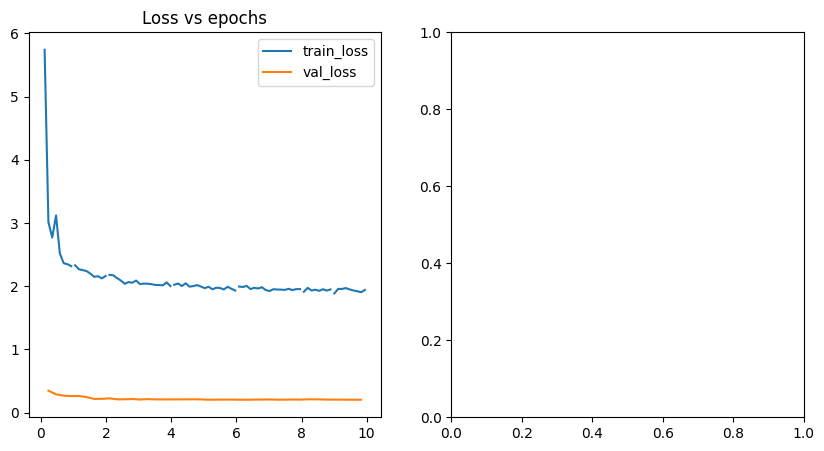

In [56]:
n_step_per_epoch = 13
fig, axs = plt.subplots(1,2,figsize=(10,5))

axs[0].plot(df['train/epoch'],df['train/loss'],label='train_loss')
axs[0].plot(df_eval['train/epoch'],df_eval['eval/loss'],label='val_loss')
axs[0].set_title('Loss vs epochs')
axs[0].legend()

axs[1].plot(df_eval['train_epoch'],df_eval['eval/wer'],label='val_WER')
axs[1].axhline(y=0.105, color='red', linestyle='--', linewidth=2, label='facebook/wav2vec2-large-960h_WER')
axs[1].legend()

In [55]:
df

tag,step,eval/loss,eval/runtime,eval/samples_per_second,eval/steps_per_second,eval/wer,train/epoch,train/grad_norm,train/learning_rate,train/loss,train/total_flos,train/train_loss,train/train_runtime,train/train_samples_per_second,train/train_steps_per_second
0,250,NaN,NaN,NaN,NaN,NaN,0.116986,4.505060,1.245000e-05,5.7395,NaN,NaN,NaN,NaN,NaN
1,500,0.348863,543.120422,107.920998,6.746,0.160453,0.233973,4.511003,2.495000e-05,3.0132,NaN,NaN,NaN,NaN,NaN
2,750,NaN,NaN,NaN,NaN,NaN,0.350959,10.393481,3.745000e-05,2.7697,NaN,NaN,NaN,NaN,NaN
3,1000,0.290724,388.408112,150.908005,9.433,0.142375,0.467946,3.137352,4.985000e-05,3.1198,NaN,NaN,NaN,NaN,NaN
4,1250,NaN,NaN,NaN,NaN,NaN,0.584932,3.554898,3.913808e-05,2.5175,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,20500,0.204979,546.450989,107.263000,6.705,0.104026,9.592887,3.031529,2.152676e-06,1.9335,NaN,NaN,NaN,NaN,NaN
88,20750,NaN,NaN,NaN,NaN,NaN,9.709873,1.951654,1.539028e-06,1.9213,NaN,NaN,NaN,NaN,NaN
89,21000,0.206288,388.615997,150.828003,9.428,0.103809,9.826860,3.339163,9.253804e-07,1.9053,NaN,NaN,NaN,NaN,NaN
90,21250,NaN,NaN,NaN,NaN,NaN,9.943847,2.509146,3.117329e-07,1.9410,NaN,NaN,NaN,NaN,NaN


In [11]:
# Load audio file
audio_file = "/home/tfc/asr_project/common_voice/cv-valid-train/cv-valid-train/sample-000000.wav"  # Replace with your audio file path
waveform, sample_rate = torchaudio.load(audio_file)


# If the sample rate is not 16kHz, resample it
if sample_rate != 16000:
    resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=16000)
    waveform = resampler(waveform)

# Convert to the right format for the model
input_values = processor(waveform.squeeze().numpy(), sampling_rate=16000, return_tensors="pt").input_values

# Get logits from the model
model.to('cpu')
with torch.no_grad():
    logits = model(input_values).logits

# Get predicted ids
predicted_ids = logits.argmax(dim=-1)

# Decode the predicted ids to text
transcription = processor.batch_decode(predicted_ids)

print(transcription)  # Print the transcription result

/home/tfc/anaconda3/envs/asr/lib/python3.12/site-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


['<s>LEARNED TO RECOGNIZE TH EROMANS AND FOLLOW THEMTHE OLD KING HAD SAID</s>']


In [8]:

# Specify the path where the fine-tuned model is saved
model_dir = os.path.expanduser('~/asr_project/asr-train/model_outputs/checkpoint-2137')

model = Wav2Vec2ForCTC.from_pretrained(
    model_dir
)
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-large-960h")


In [ ]:
def map_to_result(batch):
    with torch.no_grad():
        input_values = torch.tensor(batch["input_values"], device="cuda").unsqueeze(0)
        logits = model(input_values).logits

    pred_ids = torch.argmax(logits, dim=-1)
    batch["pred_str"] = processor.batch_decode(pred_ids)[0]
    batch["text"] = processor.decode(batch["labels"], group_tokens=False)
  
    return batch

model.to('cuda')
results = dataset["val"].map(map_to_result, remove_columns=dataset["val"].column_names)

In [ ]:
def remove_start_end_tags(batch):
    # Remove the <s> and </s> tags from both ends of each string in 'pred_str' and 'text'
    batch["pred_str"] = re.sub(r"^<s>|</s>$", "", batch["pred_str"])
    batch["text"] = re.sub(r"^<s>|</s>$", "", batch["text"])
    return batch

# Apply the function to the entire dataset
results = results.map(remove_start_end_tags)


print("Test WER: {:.3f}".format(wer_metric.compute(predictions=results["pred_str"], references=results["text"])))
# WER of 0.12 for eval set

Map: 100%|██████████| 58614/58614 [00:00<00:00, 73247.36 examples/s]


Test WER: 0.121


In [ ]:
def map_to_result(batch):
    with torch.no_grad():
        input_values = torch.tensor(batch["input_values"], device="cuda").unsqueeze(0)
        logits = model(input_values).logits

    pred_ids = torch.argmax(logits, dim=-1)
    batch["pred_str"] = processor.batch_decode(pred_ids)[0]
    batch["text"] = processor.decode(batch["labels"], group_tokens=False)
  
    return batch

model.to('cuda')
results = dataset["train"].map(map_to_result, remove_columns=dataset["train"].column_names)

Map: 100%|██████████| 136764/136764 [55:19<00:00, 41.20 examples/s] 


In [ ]:
def remove_start_end_tags(batch):
    # Remove the <s> and </s> tags from both ends of each string in 'pred_str' and 'text'
    batch["pred_str"] = re.sub(r"^<s>|</s>$", "", batch["pred_str"])
    batch["text"] = re.sub(r"^<s>|</s>$", "", batch["text"])
    return batch

# Apply the function to the entire dataset
results = results.map(remove_start_end_tags)


print("train WER: {:.3f}".format(wer_metric.compute(predictions=results["pred_str"], references=results["text"])))
# WER of 0.12 for train set.

Map: 100%|██████████| 136764/136764 [00:02<00:00, 66451.57 examples/s]


train WER: 0.120
